# Setup

Load libraries, set matplotlib to inline plotting, and create constants for analysis

In [1]:
%config InlineBackend.figure_format ='retina'
%matplotlib inline

import user_functions

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

# Set options
sns.set_style('darkgrid')
pd.set_option("display.max_rows", 10)

# set values of constants
start_year = 2007
end_year = 2017
years = [i for i in np.arange(start_year, end_year + 1)]

# local functions
def read_file(year, types = "object"):
    file_spec = np.where(year < 2014, "ic{}.zip".format(year), "adm{}.zip".format(year))
    url = "https://nces.ed.gov/ipeds/datacenter/data/{}".format(file_spec)
    answer = user_functions.net_load_data(url, types)
    answer = user_functions.fix_cols(answer)
    answer["institution_key"] = answer["unitid"].astype(int)
    answer["date_key"] = (year * 10000) + 1015
    return(answer)

# Read Data

Read data file from NCES website for each year selected, set column names to lower case for sanity, reduce to needed columns, and fill NaN with zero.  Show data frame shape (to

In [2]:
df = DataFrame()

types = {"APPLCN": np.float32,
         "APPLCNM": np.float32,
         "APPLCNW": np.float32,
         "ADMSSN": np.float32,
         "ADMSSNM": np.float32,
         "ADMSSNW": np.float32,
         "ENRLT": np.float32,
         "ENRLM": np.float32,
         "ENRLW": np.float32}

# key columns
indices = ["institution_key", "date_key"]

# value columns
cols = ["applcn", "applcnm", "applcnw", "admssn", "admssnm", "admssnw",
        "enrlt", "enrlm", "enrlw"]

for year in years:
    temp = read_file(year)
    df = pd.concat([df, temp],
                   sort = True)
    temp = None

# replace NaN
df = df.fillna(0)

print("{:,} rows and {} columns read".format(df.shape[0], df.shape[1]))

59,886 rows and 195 columns read


# Inspect Summaries

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59886 entries, 0 to 2074
Columns: 195 entries, actcm25 to yrscoll
dtypes: int64(2), object(193)
memory usage: 89.6+ MB


In [4]:
for col in cols:
    df[col] = user_functions.fix_number(df[col])

df.info()

local variable 'answer' referenced before assignment


UnboundLocalError: local variable 'answer' referenced before assignment

# Inspect First and Last Cases

In [5]:
df.iloc[[0, 1, 2, 3, 4, -5, -4, -3, -2, -1],:]

,admssn,admssnm,admssnw,applcn,applcnm,applcnw,date_key,enrlm,enrlt,enrlw,institution_key
0,0.0,0.0,0.0,0.0,0.0,0.0,20071015,0.0,0.0,0.0,100636
1,2059.0,799.0,1260.0,6470.0,2507.0,3963.0,20071015,408.0,885.0,477.0,100654
2,3705.0,1489.0,2216.0,4221.0,1674.0,2547.0,20071015,612.0,1531.0,919.0,100663
3,0.0,0.0,0.0,0.0,0.0,0.0,20071015,0.0,0.0,0.0,100690
4,1628.0,845.0,783.0,1850.0,921.0,929.0,20071015,424.0,800.0,376.0,100706
2070,14.0,14.0,0.0,15.0,15.0,0.0,20171015,12.0,12.0,0.0,491057
2071,12.0,3.0,9.0,15.0,4.0,11.0,20171015,3.0,12.0,9.0,491163
2072,0.0,0.0,0.0,2.0,2.0,0.0,20171015,0.0,0.0,0.0,491288
2073,1.0,0.0,1.0,1.0,0.0,1.0,20171015,0.0,0.0,0.0,491297
2074,4.0,1.0,3.0,5.0,2.0,3.0,20171015,1.0,4.0,3.0,491303


# Look for Potential Structural Issues

## Zero Applications, Non-zero Admissions

As long as the number of cases is small, perhaps setting apps = admits.

In [6]:
# zero apps, non-zero admits
df.loc[(df["applcn"] == 0) & (df["admssn"] > 0), :]

,admssn,admssnm,admssnw,applcn,applcnm,applcnw,date_key,enrlm,enrlt,enrlw,institution_key
3114,42.0,0.0,0.0,0.0,0.0,0.0,20071015,0.0,33.0,0.0,199883


In [7]:
df["applcn"] = np.where((df["applcn"] == 0) & (df["admssn"] > 0), df["admssn"], df["applcn"])

## Zero Admissions, Non-zero Enrollment

In [8]:
# zero admits, non-zero enrollment
df.loc[(df["admssn"] == 0) & (df["enrlt"] > 0), :]

,admssn,admssnm,admssnw,applcn,applcnm,applcnw,date_key,enrlm,enrlt,enrlw,institution_key


## Sum of Men and Women Applications is Greater than Total Applications

In [9]:
# total applications less than sum of parts
df.loc[df["applcn"] < df["applcnm"] + df["applcnw"],:]

,admssn,admssnm,admssnw,applcn,applcnm,applcnw,date_key,enrlm,enrlt,enrlw,institution_key


# Calculate Unknown Sex Categories

Calculate an unknown variable to accomodate those institutions where the total applications, admissions, and enrollment are greater than the sum of their headcounts of men and women.  This will ensure that the details roll up to the total in the final long format data frame.

In [10]:
# calculate unknowns
df["applcnu"] = df["applcn"] - (df["applcnm"] + df["applcnw"])
df["admssnu"] = df["admssn"] - (df["admssnm"] + df["admssnw"])
df["enrlu"] = df["enrlt"] - (df["enrlm"] + df["enrlw"])

df.loc[df["applcnu"] > 0, ["applcn", "applcnm", "applcnw", "applcnu"]].head()

,applcn,applcnm,applcnw,applcnu
35,883.0,0.0,0.0,883.0
42,2330.0,0.0,0.0,2330.0
85,25449.0,12163.0,13185.0,101.0
111,471.0,358.0,104.0,9.0
132,287.0,0.0,0.0,287.0


# Convert From Wide to Long

Melt the DataFrame, pivoting value columns into a single column. 
Create a field column to identify type of value.
Create a sex column to identify values by sex.

In [11]:
# reshape from wide to long format
adm_long = pd.melt(df, id_vars = indices,
                   value_vars = ["applcnm", "applcnw", "applcnu",
                                 "admssnm", "admssnw", "admssnu",
                                 "enrlm", "enrlw", "enrlu"],
                   value_name = "count")

# field indicator
adm_long["field"] = np.where(adm_long["variable"].str.slice(0, 3) == "app", "applications", "unknown")
adm_long["field"] = np.where(adm_long["variable"].str.slice(0, 3) == "adm", "admissions", adm_long["field"])
adm_long["field"] = np.where(adm_long["variable"].str.slice(0, 3) == "enr", "enrollment", adm_long["field"])

# sex indicator
adm_long["sex"] = np.where(adm_long["variable"].str.slice(-1) == "w", "women", "unknown")
adm_long["sex"] = np.where(adm_long["variable"].str.slice(-1) == "m", "men", adm_long["sex"])

adm_long.iloc[[0, 1, 2, 3, 4, -5, -4, -3, -2, -1],:]

,institution_key,date_key,variable,count,field,sex
0,100636,20071015,applcnm,0.0,applications,men
1,100654,20071015,applcnm,2507.0,applications,men
2,100663,20071015,applcnm,1674.0,applications,men
3,100690,20071015,applcnm,0.0,applications,men
4,100706,20071015,applcnm,921.0,applications,men
538969,491057,20171015,enrlu,0.0,enrollment,unknown
538970,491163,20171015,enrlu,0.0,enrollment,unknown
538971,491288,20171015,enrlu,0.0,enrollment,unknown
538972,491297,20171015,enrlu,0.0,enrollment,unknown
538973,491303,20171015,enrlu,0.0,enrollment,unknown


# Inspect Field Values

Check for unknown.  If there is an unknown value here, something has changed in naming conventions.

In [12]:
adm_long["field"].value_counts()

enrollment      179658
admissions      179658
applications    179658
Name: field, dtype: int64

# Add Demographic Key

This adds a demographic key for warehousing.  The first 5 characters are all set to "unkn" because IPEDS-ADM does not collect race/ethnicity.

In [13]:
adm_long["demographic_key"] = "unknu"
adm_long["demographic_key"] = np.where(adm_long["sex"] == "men", "unknm", adm_long["demographic_key"])
adm_long["demographic_key"] = np.where(adm_long["sex"] == "women", "unknw", adm_long["demographic_key"])

adm_long["demographic_key"].value_counts()

unknw    179658
unknm    179658
unknu    179658
Name: demographic_key, dtype: int64

# Pivot Long Data to Final Format

Pivot and aggregate (sum) the count column, converting the field variable back into three measures: applications, admissions, and enrollment.  For warehousing, we will eventually drop the sex field, but it is kept here for data checking purposes.

In [14]:
adm = adm_long.pivot_table(index=["institution_key", "date_key", "demographic_key"],
                           columns='field',
                           values='count',
                           aggfunc = np.sum,
                           fill_value = 0).reset_index()

# remove institutions with no applications
adm = adm.loc[adm["applications"] > 0]

adm.iloc[[0, 1, 2, 3, 4, -5, -4, -3, -2, -1],:]

field,institution_key,date_key,demographic_key,admissions,applications,enrollment
18,100654,20071015,unknm,799,2507,408
20,100654,20071015,unknw,1260,3963,477
21,100654,20081015,unknm,837,1664,476
23,100654,20081015,unknw,1104,2297,570
24,100654,20091015,unknm,1059,2273,507
179648,491163,20171015,unknw,9,11,9
179649,491288,20171015,unknm,0,2,0
179654,491297,20171015,unknw,1,1,0
179655,491303,20171015,unknm,1,2,1
179657,491303,20171015,unknw,3,3,3


# Write Data to Warehouse (later)

In [ ]:
from sqlalchemy import create_engine

engine = create_engine('mssql+pyodbc://ched-dev', legacy_schema_aliasing = True)

adm_to_db = adm[["institution_key", "date_key", "demographic_key", "applications", "admissions", "enrollment"]]

adm_to_db.to_sql('admissions_measures',
                 engine,
                 if_exists = "append",
                 index = False)

engine = None

# Create Some Variables and Do Basic Exploration

In [23]:
viz_set = adm.groupby(["institution_key",
                       "date_key"]).agg({"admissions": np.sum,
                                         "applications": np.sum,
                                         "enrollment": np.sum}).reset_index()
viz_set["acceptance_rate"] = viz_set["admissions"] / viz_set["applications"]
viz_set["yield_rate"] = viz_set["enrollment"] / viz_set["admissions"]
viz_set["isUNL"] = np.where(viz_set["institution_key"] == 181464, 1, 0)

cases = (viz_set["date_key"] == 20171015) & (viz_set["acceptance_rate"] < 1.0) & (viz_set["yield_rate"] < 1.0)
viz_set = viz_set[cases]

viz_set.shape

(1905, 8)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


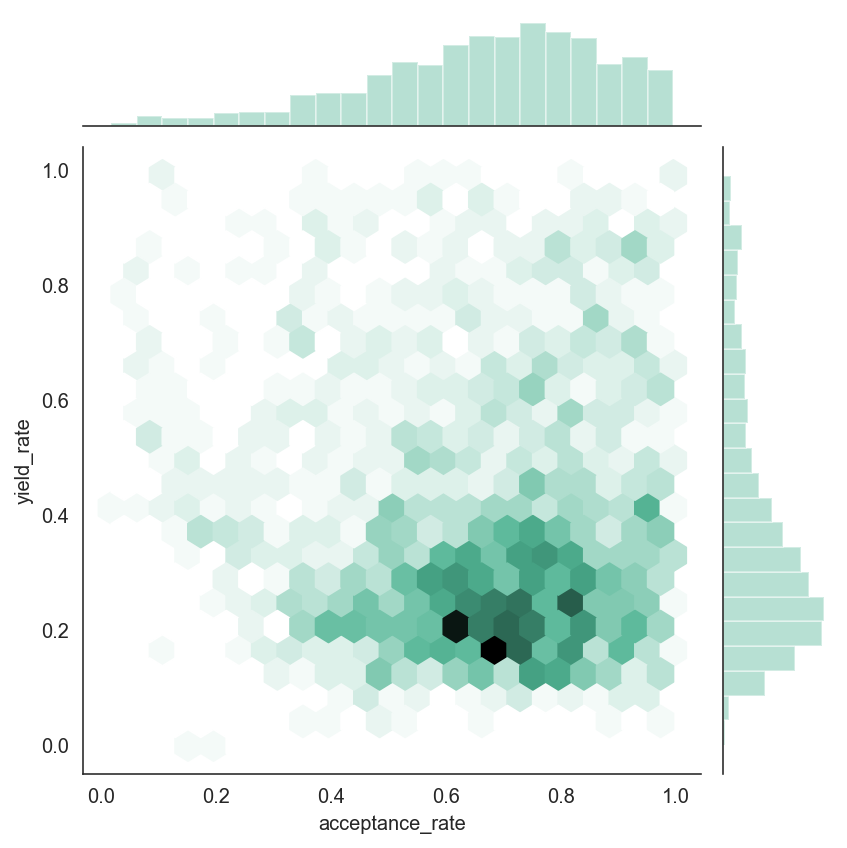

In [24]:
with sns.axes_style('white'):
    sns.jointplot(x = "acceptance_rate",
                  y = "yield_rate",
                  data = viz_set,
                  kind="hex",
                  color="#4CB391")

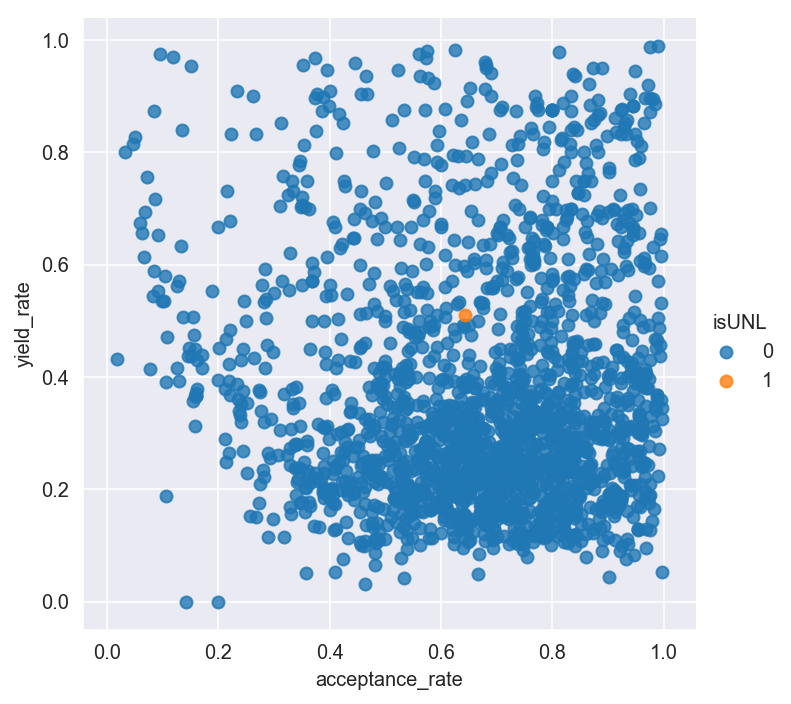

In [27]:
sns.lmplot(x = "acceptance_rate",
           y = "yield_rate",
           data = viz_set,
           fit_reg = False,
           hue='isUNL')

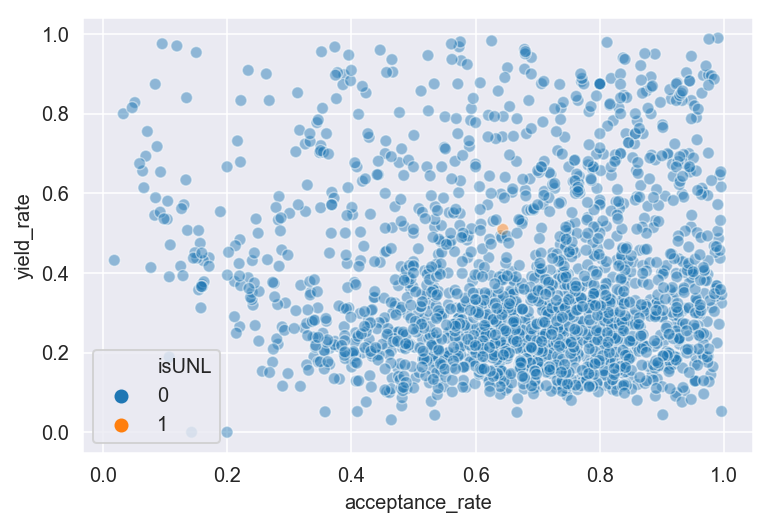

In [40]:
sns.scatterplot(x = "acceptance_rate",
                y = "yield_rate",
                data = viz_set,
                hue = "isUNL",
                alpha = 0.45)